In [1]:
import numpy as np
import pandas as pd
import gc
import os
import sys
import yaml
import re
import random
import math
import matplotlib.pyplot as plt
import warnings
import pickle
from tqdm.notebook import tqdm
from typing import *
from pathlib import Path
from dataclasses import dataclass, field, asdict
from shutil import copyfile
from cuml.neighbors import NearestNeighbors
warnings.simplefilter('ignore')

In [2]:
@dataclass
class Config:
    outdir: str = "../results/efficientnet-tpu"
    device: str = "cuda:1"
    device_id: int = 1

    datadir: str = '../data/tfrecord-skf'
    image_dir: str = '../data/shopee-product-matching/train_images'
    seed: int = 42
    n_splits: int = 3
    tf_expt: int = -1
    image_size: List[int] = field(default_factory=lambda: [512, 512])
    
    # Training config
    batch_size: int = 20
    epochs: int = 100
    patience: int = 5
    lr: float = 0.00001

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [4]:
config = Config()
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.device_id)

base_dir = Path().resolve()
sys.path.append(os.path.abspath(base_dir / '../'))

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn

from src.tokenization import *
from src.preprocess import *
from src.image import *
from src.model import *

In [5]:
# Function to get our f1 score
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1


def precision_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    return intersection / len_y_pred


def recall_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_true = y_true.apply(lambda x: len(x)).values
    return intersection / len_y_true

In [6]:
# Function to read our test image and return image
def read_image(image, image_size):
    image = tf.io.read_file(image)
    image = decode_image(image, image_size)
    return image


# Function to get our dataset that read images
def get_dataset(image, config):
    dataset = tf.data.Dataset.from_tensor_slices(image)
    dataset = dataset.map(lambda x: read_image(x, config.image_size), num_parallel_calls = config.tf_expt)
    dataset = dataset.batch(config.batch_size)
    dataset = dataset.prefetch(config.tf_expt)
    return dataset

In [7]:
train = pd.read_csv(base_dir / config.datadir / 'train_folds.csv')
n_classes = train['label_group'].nunique()
n_classes

11014

In [8]:
def get_embeddings(df: pd.DataFrame, weight_path: Path, en_type: str):
    image_paths = [str(base_dir / config.image_dir / filename) for filename in df['image']]
    
    if en_type is None:
        model = build_resnext_model(
            n_classes=n_classes,
            image_size=config.image_size,
            lr=config.lr,
            train=False
        )
    else:
        model = build_efficientnet_model(
            n_classes=n_classes,
            image_size=config.image_size,
            lr=config.lr,
            en_type=en_type,
            train=False
        )
        
    model.load_weights(str(weight_path))
    model1 = tf.keras.models.Model(inputs=model.input[0:3], outputs=model.layers[-4].output)
#     arc_W = model.layers[-2].W
#     get_cosine = lambda X: tf.matmul(tf.math.l2_normalize(X, axis=1), tf.math.l2_normalize(arc_W, axis=0)).numpy()
    
    del model
    gc.collect()
    
    chunk = 500
    iterator = np.arange(np.ceil(len(df) / chunk))

    embeds = []
    cosines = []
    for j in tqdm(iterator):
        a = int(j * chunk)
        b = int((j + 1) * chunk)

        image_dataset = get_dataset(image_paths[a:b], config)
        embeddings = model1.predict(image_dataset)
#         cosine = get_cosine(embeddings)
        
        embeds.append(embeddings)
#         cosines.append(cosine)
    
    del model1
    gc.collect()
    tf.keras.backend.clear_session()
    return np.concatenate(embeds), []

In [9]:
def get_valid_df(fold: int):
    valid_folds = [i for i in range(train.fold.unique().shape[0]) if (i % config.n_splits) == fold]
    print(f'folds : {valid_folds}')
    
    valid_df = train.query(f'fold in {valid_folds}').copy()
    return valid_df

In [10]:
def get_embeddings_list(epoch: int, en_type: str):
    epoch = format(epoch, '02') + '_'
    embeddings_list = list()
    cosines_list = list()
    for i in range(config.n_splits):
        if en_type is None:
            outdir = base_dir / config.outdir / f'resnext50_seed{config.seed}_fold{i}'
        else:
            outdir = base_dir / config.outdir / f'EfficientNet{en_type}_seed{config.seed}_fold{i}'
        weight_path = outdir / f'epoch{epoch}.h5'
        emb_outpath = outdir / f'embeddings_epoch{epoch}.pkl'
        cosine_outpath = outdir / f'cosine_epoch{epoch}.pkl'

        if os.path.exists(emb_outpath) and os.path.exists(cosine_outpath):
            print('get embeddings and cosines from the cashe')
            embeddings = pickle.load(open(str(emb_outpath), 'rb'))
            cosines = pickle.load(open(str(cosine_outpath), 'rb'))
        else:
            embeddings, cosines = get_embeddings(
                df=train,
                weight_path=weight_path,
                en_type=en_type
            )
            pickle.dump(
                embeddings,
                open(str(emb_outpath), 'wb')
            )
            pickle.dump(
                cosines,
                open(str(cosine_outpath), 'wb')
            )
        embeddings_list += [embeddings]
        cosines_list += [cosines]
                
    return embeddings_list, cosines_list

In [11]:
def get_matches(df: pd.DataFrame, distance: np.ndarray, indice: np.ndarray, thr: float) -> List[str]:
        idx = np.where(distance < thr)[0]
        ids = indice[idx]
        return df['posting_id'].iloc[ids].values.tolist()
    
    
def search_thresholds(df: pd.DataFrame, embeddings: np.ndarray, fold: int, knn: int = 50, metric: str = 'euclidean',
                      thr_start: int = 3, thr_end: int = 5, thr_interval: float = 0.1, same_cls: bool = True):
    # KNN
    knn_model = NearestNeighbors(n_neighbors=knn, metric=metric)
    knn_model.fit(embeddings)

    valid_df = get_valid_df(fold=fold)
    valid_embeddings = embeddings[valid_df.index, :]
    distances, indices = knn_model.kneighbors(valid_embeddings)

    # grid search
    thresholds = list(np.arange(thr_start, thr_end, thr_interval))
    scores = []
    for threshold in thresholds:
        predictions = []
        for k in range(valid_embeddings.shape[0]):

            matches = get_matches(df=df, distance=distances[k, ], indice=indices[k, ], thr=threshold)
            posting_ids = ' '.join(matches)
            predictions.append(posting_ids)
        valid_df['pred_matches'] = predictions
        valid_df['f1'] = f1_score(valid_df['matches'], valid_df['pred_matches'])
        score = valid_df['f1'].mean()
        print(f'Our f1 score for threshold {np.round(threshold, 2)} is {score}')
        scores.append(score)
    thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})

    max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
    best_threshold = max_score['thresholds'].values[0]
    best_score = max_score['scores'].values[0]
    print(f'Our best score is {best_score} and has a threshold {best_threshold}')
    
    return best_score, best_threshold

In [12]:
# for RexNext
get_embeddings_list(epoch=20, en_type=None)

  0%|          | 0/69 [00:00<?, ?it/s]

OSError: Unable to open file (unable to open file: name = '/home/yamaguchi-milkcocholate/Shopee/notebooks/../results/efficientnet-tpu/resnext50_seed42_fold1/epoch20_.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [30]:
b3 = getattr(efn, f'EfficientNetB3')(weights = 'imagenet', include_top = True, classes=1000)

50094080/50086816 [==============================] - 2s 0us/step


In [31]:
b3.output

<tf.Tensor 'probs/Softmax:0' shape=(None, 1000) dtype=float32>

In [16]:
model = build_efficientnet_model(
    n_classes=n_classes,
    image_size=config.image_size,
    lr=config.lr,
    en_type='B3',
    train=False
)

outdir = base_dir / config.outdir / f'EfficientNetB3_seed42_fold0'
weight_outpath = outdir / f'epoch20.h5'
model.load_weights(str(weight_outpath))

In [24]:
model.layers[0]

<tf.Tensor 'inp1_3:0' shape=(None, 512, 512, 3) dtype=float32>

In [20]:
model.layers[2].output

<tf.Tensor 'global_average_pooling2d_2/Mean:0' shape=(None, 1536) dtype=float32>

In [ ]:
outdir = base_dir / config.outdir / f'resnext50_seed{config.seed}_fold0'
emb_outpath = outdir / f'embeddings_epoch20.pkl'
embeddings = pickle.load(open(emb_outpath, 'rb'))
search_thresholds(train, embeddings, 0, 50, 'cosine', 0, 1, 0.1)

In [13]:
outdir = base_dir / config.outdir / f'resnext50_seed{config.seed}_fold0'
emb_outpath = outdir / f'embeddings_epoch20_.pkl'
embeddings = pickle.load(open(emb_outpath, 'rb'))
search_thresholds(train, embeddings, 0, 50, 'cosine', 0, 1, 0.1)

folds : [0, 3, 6, 9, 12]
Our f1 score for threshold 0.0 is 0.040170322002757525
Our f1 score for threshold 0.1 is 0.7175815678125432
Our f1 score for threshold 0.2 is 0.7634884301447495
Our f1 score for threshold 0.3 is 0.7913182946863226
Our f1 score for threshold 0.4 is 0.8029113301037403
Our f1 score for threshold 0.5 is 0.7524545124824131
Our f1 score for threshold 0.6 is 0.47847318946951556
Our f1 score for threshold 0.7 is 0.1860227506448089
Our f1 score for threshold 0.8 is 0.16858341384838194
Our f1 score for threshold 0.9 is 0.16858341384838194
Our best score is 0.8029113301037403 and has a threshold 0.4


(0.8029113301037403, 0.4)

In [79]:
en_type = 'B0'
embeddings_list, cosines_list = get_embeddings_list(epoch=20, en_type=en_type)
results_b0 = list()

for i in range(config.n_splits):
    train['pred_cls'] = cosines_list[i].argmax(axis=1)
    train['pred_cls_score'] = cosines_list[i].max(axis=1)
    results_b0 += [search_thresholds(train, embeddings_list[i], i, 50, 3, 5, 0.2, True)]

get embeddings and cosines from the cashe
get embeddings and cosines from the cashe
get embeddings and cosines from the cashe
folds : [0, 3, 6, 9, 12]
Our f1 score for threshold 3.0 is 0.6886520338650142
Our f1 score for threshold 3.2 is 0.7043530124451866
Our f1 score for threshold 3.4 is 0.7202712559611227
Our f1 score for threshold 3.6 is 0.7369179399912072
Our f1 score for threshold 3.8 is 0.7547112836845911
Our f1 score for threshold 4.0 is 0.771246097130789
Our f1 score for threshold 4.2 is 0.7853877159082585
Our f1 score for threshold 4.4 is 0.7955345602601085
Our f1 score for threshold 4.6 is 0.8016475672640402
Our f1 score for threshold 4.8 is 0.8059719237369197
Our best score is 0.8059719237369197 and has a threshold 4.800000000000002
folds : [1, 4, 7, 10, 13]
Our f1 score for threshold 3.0 is 0.6839445979730524
Our f1 score for threshold 3.2 is 0.6993485126080224
Our f1 score for threshold 3.4 is 0.7155358436412658
Our f1 score for threshold 3.6 is 0.7331491471274868
Our f1 

In [77]:
en_type = 'B3'
embeddings_list, cosines_list = get_embeddings_list(epoch=20, en_type=en_type)
results_bb = list()

for i in range(config.n_splits):
    train['pred_cls'] = cosines_list[i].argmax(axis=1)
    train['pred_cls_score'] = cosines_list[i].max(axis=1)
    results_bb += [search_thresholds(train, embeddings_list[i], i, 50, 5, 8, 0.2, True)]

get embeddings and cosines from the cashe
get embeddings and cosines from the cashe
get embeddings and cosines from the cashe
folds : [0, 3, 6, 9, 12]
Our f1 score for threshold 5.0 is 0.8148465702502612
Our f1 score for threshold 5.2 is 0.8160622460520118
Our f1 score for threshold 5.4 is 0.8159231270325623
Our f1 score for threshold 5.6 is 0.8161519488353646
Our f1 score for threshold 5.8 is 0.816251879575747
Our f1 score for threshold 6.0 is 0.8160810712044011
Our f1 score for threshold 6.2 is 0.8161196904904022
Our f1 score for threshold 6.4 is 0.8161206433637028
Our f1 score for threshold 6.6 is 0.8162285728851402
Our f1 score for threshold 6.8 is 0.8163054127718121
Our f1 score for threshold 7.0 is 0.8162409959384926
Our f1 score for threshold 7.2 is 0.8162630671416403
Our f1 score for threshold 7.4 is 0.8162787792741797
Our f1 score for threshold 7.6 is 0.8162588101021965
Our f1 score for threshold 7.8 is 0.8162668053721329
Our best score is 0.8163054127718121 and has a threshol

In [16]:
en_type = 'B5'
embeddings_list = get_embeddings_list(epoch=20, en_type=en_type)
# results_b5 = list()

# for i in range(config.n_splits):
#     print(f'fold : {i}')
#     results_b5 += [search_thresholds(train, embeddings_list[i], i, 50, 3, 5, 0.1)]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

In [78]:
en_type = 'B3'
embeddings_list, cosines_list = get_embeddings_list(epoch=20, en_type=en_type)
results_bb = list()

for i in range(config.n_splits):
    train['pred_cls'] = cosines_list[i].argmax(axis=1)
    train['pred_cls_score'] = cosines_list[i].max(axis=1)
    results_bb += [search_thresholds(train, embeddings_list[i], i, 50, 2, 8, 0.2, False)]

get embeddings and cosines from the cashe
get embeddings and cosines from the cashe
get embeddings and cosines from the cashe
folds : [0, 3, 6, 9, 12]
Our f1 score for threshold 2.0 is 0.0005892931834123762
Our f1 score for threshold 2.2 is 0.0006345187128229959
Our f1 score for threshold 2.4 is 0.0009213621721285732
Our f1 score for threshold 2.6 is 0.001249125960940151
Our f1 score for threshold 2.8 is 0.0014829948818045977
Our f1 score for threshold 3.0 is 0.0019988098570774475
Our f1 score for threshold 3.2 is 0.0029356278238012374
Our f1 score for threshold 3.4 is 0.0038192982357084563
Our f1 score for threshold 3.6 is 0.004853335867036099
Our f1 score for threshold 3.8 is 0.007156967201059351
Our f1 score for threshold 4.0 is 0.009500712664764377
Our f1 score for threshold 4.2 is 0.01322986311156726
Our f1 score for threshold 4.4 is 0.01658450491662283
Our f1 score for threshold 4.6 is 0.019832588400535867
Our f1 score for threshold 4.8 is 0.018198320127190023
Our f1 score for th

In [90]:
# for entype in ['B0', 'B3', 'B5']:
#     for fold in range(3):
#         emb_outdir = base_dir / config.outdir / f'EfficientNet{entype}_seed42_fold{fold}' / 'embeddings_epoch20.pkl'
#         cos_outdir = base_dir / config.outdir / f'EfficientNet{entype}_seed42_fold{fold}' / 'cosine_epoch20.pkl'
        
#         emb = pickle.load(open(emb_outdir, 'rb'))
#         cos = pickle.load(open(cos_outdir, 'rb'))
        
#         pickle.dump(emb, open(base_dir / f'{entype}_{fold}_emb.pkl', 'wb'))
#         pickle.dump(cos, open(base_dir / f'{entype}_{fold}_cos.pkl', 'wb'))

In [17]:
entype = 'B3'
fold = 0
emb_outdir = base_dir / config.outdir / f'EfficientNet{entype}_seed42_fold{fold}' / 'embeddings_epoch20.pkl'
cos_outdir = base_dir / config.outdir / f'EfficientNet{entype}_seed42_fold{fold}' / 'cosine_epoch20.pkl'
emb = pickle.load(open(emb_outdir, 'rb'))
cos = pickle.load(open(cos_outdir, 'rb'))

In [18]:
knn_model = NearestNeighbors(n_neighbors=50)
knn_model.fit(emb)

valid_df = get_valid_df(fold=fold)
valid_emb = emb[valid_df.index, :]
distances, indices = knn_model.kneighbors(valid_emb)

folds : [0, 3, 6, 9, 12]


In [26]:
train['pred_cls'] = cos.argmax(axis=1)
train['pred_cls_score'] = cos.max(axis=1)

In [ ]:

results_b3 = list()
for i in range(config.n_splits):
    print(f'fold : {i}')
    results_b3 += [search_thresholds(train, embeddings_list[i], i, 50, 4, 7, 0.1, True)]

In [31]:
# KNN prediction
threshold = 4.2
predictions = []
for k in range(valid_emb.shape[0]):
    idx = np.where(distances[k, ] < threshold)[0]
    ids = indices[k, idx]
    posting_ids = ' '.join(train['posting_id'].iloc[ids].values)
    predictions.append(posting_ids)
valid_df['pred_matches'] = predictions
valid_df['f1'] = f1_score(valid_df['matches'], valid_df['pred_matches'])
valid_df['recall'] = recall_score(valid_df['matches'], valid_df['pred_matches'])
valid_df['precision'] = precision_score(valid_df['matches'], valid_df['pred_matches'])
valid_df['pred_cls'] = train.loc[valid_df.index, 'pred_cls']
valid_df['pred_cls_score'] = train.loc[valid_df.index, 'pred_cls_score']

In [45]:
pred_cls, pred_cls_score = valid_df.loc[4, ['pred_cls', 'pred_cls_score']]
train.query('pred_cls == @pred_cls')

,posting_id,image,image_phash,title,label_group,matches,f1,fold,pred_cls,pred_cls_score
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,4,train_3369186413 train_921438619,0.666667,9,4,0.672321
18449,train_921438619,8b0e60baf319fa282242ab1739df10e0.jpg,e69999663199cc93,Nescafe Eclair Latte Pet 220 Ml,4,train_3369186413 train_921438619,0.666667,8,4,0.897108


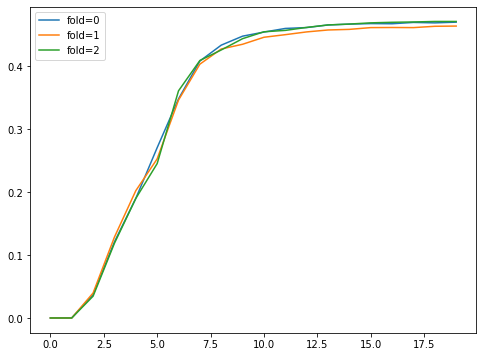

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(config.n_splits):
    history = pickle.load(open(str(base_dir / config.outdir / f'EfficientNetB3_seed{config.seed}_fold{i}' / 'history.pkl'), 'rb'))
    y = history['val_sparse_categorical_accuracy']
    ax.plot(y, label=f'fold={i}')
ax.legend()
plt.show()

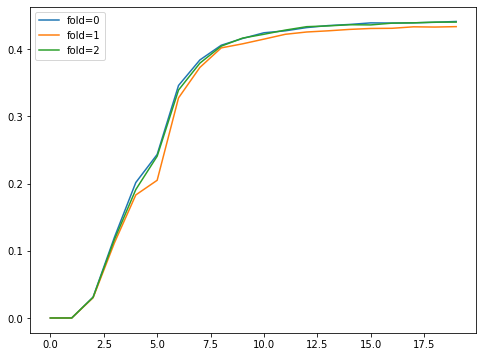

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(config.n_splits):
    history = pickle.load(open(str(base_dir / config.outdir / f'EfficientNetB0_seed{config.seed}_fold{i}' / 'history.pkl'), 'rb'))
    y = history['val_sparse_categorical_accuracy']
    ax.plot(y, label=f'fold={i}')
ax.legend()
plt.show()

In [31]:
x = np.array([1, 1, 0, 1], dtype=bool)
np.multiply.accumulate(x).sum()



2